In [1]:
"""
Created on Fri Sep 22 12:26:33 2017

@author: Manikanda Krishnan V (06-02-02-10-22-17-1-14787)
"""


'\nCreated on Fri Sep 22 12:26:33 2017\n\n@author: Manikanda Krishnan V (06-02-02-10-22-17-1-14787)\n'

An image is padded with extra pixels in order to perform the convolution operation on the boundary pixels. Different types of padding lead to different effects. 

Constant Padding - The boundary are padded with pixels having a particular value. If this value is 0 then it becomes zero padding.
In Morphological Processing - For erosion , a one padding is used and for dilation a zero padding is used.

Periodic Padding - In this scheme the image is repeated(tiled). This corresponds to periodic convolution, images generally do not satisfy this assumption i.e the texture on the right border can be very different from the left border etc, hence this also leads to discontinuities.

Symmetric Padding - In this scheme the pixels are reflected across the boundary. This leads to smoother transitions at the boundary preventing the creation of high frequency components


In [2]:
def padImage(im,filter_shape,padding_type="zero",constant = 0) :
    im_size = im.shape 
    padding_thickness = [x/2 for x in filter_shape]
    lower_corner = (padding_thickness[0]+im_size[0],padding_thickness[1]+im_size[1])
    im_col_flipped = im[:,-1::-1]
    im_row_flipped = im[-1::-1,:]
    im_both_flipped = im[-1::-1,-1::-1]
    zeros = np.ones(im_size)*constant #constant padding on the borders, since default value of constant is 0, this becomes zero padding.
    if padding_type == "zero" :
            new_im = np.vstack([np.hstack([zeros,zeros,zeros]),
                                np.hstack([zeros,im,zeros]),
                                np.hstack([zeros,zeros,zeros])])

    elif padding_type == "symmetric" :
            new_im = np.vstack([np.hstack([im_both_flipped,im_row_flipped,im_both_flipped]),
                                np.hstack([im_col_flipped,im,im_col_flipped]),
                                np.hstack([im_both_flipped,im_row_flipped,im_both_flipped])])
    elif padding_type == "periodic" :
            new_im = np.vstack([np.hstack([im,im,im]),
                                np.hstack([im,im,im]),
                                np.hstack([im,im,im])])

    return new_im[im_size[0]-padding_thickness[0]:2*im_size[0]+padding_thickness[0],im_size[1]-padding_thickness[1]:2*im_size[1]+padding_thickness[1]]

This is a generalization of the 2D correlation operator. The operator argument is a function that takes a neighborhood of size mask_shape and returns a constant. If the operator does a 2D dot product we will get 2D correlation

In [3]:
def non_linear_neighborhood_processing(image,mask_shape,operator,padding_type="zero",constant = 0) :
    """
        operator is a function that takes a neighborhood of mask_shape as input and returns a value .
    """
    im = padImage(image,mask_shape,padding_type,constant)
    new_image = np.zeros(image.shape)
    for x in range(0,image.shape[0]) :
        for y in range(0,image.shape[1]) :
            new_image[x,y] = operator(im[x:x+mask_shape[0],y:y+mask_shape[1]])
    return new_image            

If the entire mask fits inside the neighborhood then we should get back the mask after product and that pixel should take the value 1 else the pixel should be marked as 0

In [4]:
def erosion_operator(mask,neighborhood) :
    output = mask*neighborhood
    return np.alltrue(mask == output)*1.0

If there is any overlap between the mask and the ROI , then we should mark it as 1. Here we check if the mask completely lies on the background , if yes then 0 else it implies it has some overlap and hence it will take the value 1

In [5]:
def dilation_operator(mask,neighborhood) :
    output = mask*neighborhood
    return 1.0 - np.alltrue(output == 0)

performs  erosion by using the erosion operator defined previously

In [6]:
def erosion(image,mask) :
    return non_linear_neighborhood_processing(image,mask.shape,lambda x : erosion_operator(mask,x),constant = 1)

In [7]:
def dilation(image,mask) :
    return non_linear_neighborhood_processing(image,mask.shape,lambda x : dilation_operator(mask,x),constant = 0)

Open is erosion followed by dilation

In [8]:
def morph_open(image,mask) :
    return dilation(erosion(image,mask),mask)

close is dilation followed by erosion

In [9]:
def morph_close(image,mask) :
    return erosion(dilation(image,mask),mask)

Morphological Gradient is the difference between dilated image and eroded image. It highlights corners in the figure

In [10]:
def morph_gradient(image,mask) :
    return dilation(image,mask) - erosion(image,mask)

This creates a disk element of radius r with centre at centre of the matrix of dimension 2*r+1, all elements whose euclidean distance is less than r is marked as 1

In [11]:
def getDiskElement(radius) :
    r = int(radius)
    element = np.zeros((2*r+1,2*r+1))
    c = r + 1
    for i in range(1,2*r+2) :
        for j in range(1,2*r+2) :
            element[i-1,j-1] = 1.0*(((i-c)**2+(j-c)**2) <= r**2)
    return element

This creates a diamond element with centre at centre of the matrix of dimension 2*half_diagonal+1. Half_diagonal is the distance between the vertex and the point of intersection of the diagonals of the diamond. All elements whose manhattan distance is less than half_diagonal is marked as 1

In [12]:
def getDiamondElement(half_diagonal) :
    r = int(half_diagonal)
    element = np.zeros((2*r+1,2*r+1))
    c = r + 1
    for i in range(1,2*r+2) :
        for j in range(1,2*r+2) :
            element[i-1,j-1] = 1.0*((np.abs(i-c)+np.abs(j-c)) <= r)
    return element

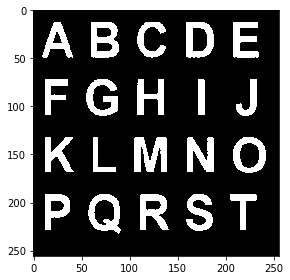

Diamond Element :
[[ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  1.  1.  0.  0.]
 [ 0.  1.  1.  1.  1.  1.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 0.  1.  1.  1.  1.  1.  0.]
 [ 0.  0.  1.  1.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]]
Eroded


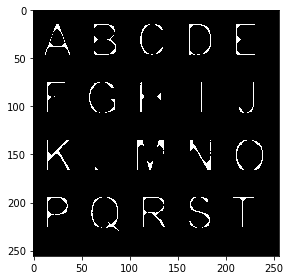

Dilated


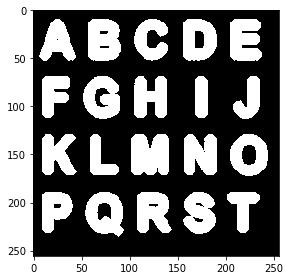

Opened


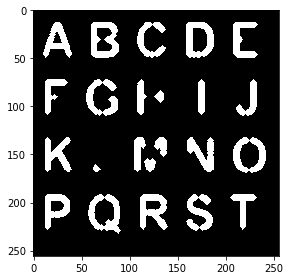

Closed


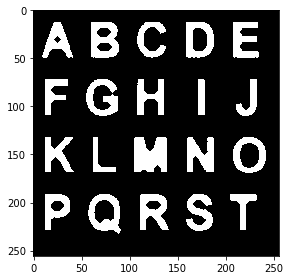

Gradient


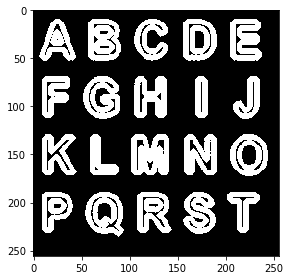

In [13]:
import numpy as np
from skimage import io,color,transform,img_as_ubyte
import matplotlib.pyplot as plt
import math

ocr_path = r"C:\Users\Sephiroth\Downloads\iisc\DIP codes\ocr_custom.jpg"
im = (transform.resize(color.rgb2gray(io.imread(ocr_path)),(256,256)) < 0.5)*1.0
io.imshow(im)
plt.show()

diamond_mask =  getDiamondElement(3)

print "Diamond Element :"
print diamond_mask

print  "Eroded"
eroded  = erosion(im,diamond_mask)
io.imshow(eroded)
plt.show()

print  "Dilated"
dilate  = dilation(im,diamond_mask)
io.imshow(dilate)
plt.show()

print  "Opened"
ope = morph_open(im,diamond_mask) 
io.imshow(ope)
plt.show()

print  "Closed"
clos = morph_close(im,diamond_mask) 
io.imshow(clos)
plt.show()

print "Gradient"
grad = morph_gradient(im,diamond_mask)
io.imshow(grad)
plt.show()




DiskElement :
[[ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  1.  1.  1.  1.  0.]
 [ 0.  1.  1.  1.  1.  1.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 0.  1.  1.  1.  1.  1.  0.]
 [ 0.  1.  1.  1.  1.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]]
Eroded


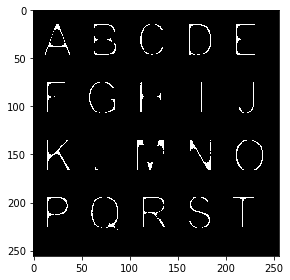

Dilated


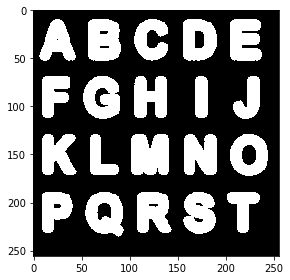

Opened


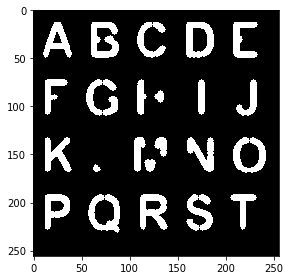

Closed


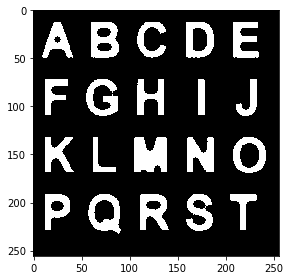

Gradient


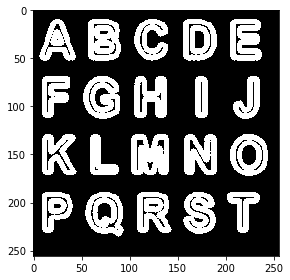

In [14]:
disk_mask =  getDiskElement(3)

print "\n\nDiskElement :"
print disk_mask

print  "Eroded"
eroded  = erosion(im,disk_mask)
io.imshow(eroded)
plt.show()
print  "Dilated"
dilate  = dilation(im,disk_mask)
io.imshow(dilate)
plt.show()

print  "Opened"
ope = morph_open(im,disk_mask) 
io.imshow(ope)
plt.show()
print "Closed"
clos = morph_close(im,disk_mask) 
io.imshow(clos)
plt.show()

print "Gradient"
grad = morph_gradient(im,disk_mask)
io.imshow(grad)
plt.show()


From the closed images we can notice that the hole shape became diamond for diamond masks and circular for the circular masks